In [ ]:
import random
import numpy as np
import pandas as pd
import chess
import chess.pgn
import pickle
import threading
from tqdm import tqdm
import os
import time

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU, Input
from keras.layers import add
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.types.core import ConcreteFunction

from tensorflow.keras.optimizers import Adam

In [2]:
def create_model():
    # Input layer
    input_board = keras.layers.Input(shape=(8,8,119))
    output_shape = (8*8*73,1)

    # Convolutional layers
    conv1 = keras.layers.Conv2D(119, (3,3), activation='relu', padding='same')(input_board)
    conv2 = keras.layers.Conv2D(119, (3,3), activation='relu', padding='same')(conv1)
    conv3 = keras.layers.Conv2D(119, (3,3), activation='relu', padding='same')(conv2)
    conv4 = keras.layers.Conv2D(119, (3,3), activation='relu', padding='same')(conv3)

    # Policy head
    policy_head = keras.models.Sequential(name='policy_head')
    policy_head.add(keras.layers.Conv2D(2, kernel_size=(1, 1), strides=(1, 1), input_shape=(8,8,119), padding='same', data_format='channels_last'))
    policy_head.add(keras.layers.BatchNormalization(axis=1))
    policy_head.add(keras.layers.Activation('relu'))
    policy_head.add(keras.layers.Flatten())
    policy_head.add(keras.layers.Dense(output_shape[0], activation="softmax", name='policy_head'))
    policy_output = policy_head(conv4)

    # Value head
    value_head = keras.models.Sequential(name='value_head')
    value_head.add(keras.layers.Conv2D(1, kernel_size=(1, 1), strides=(1, 1), input_shape=(8,8,119), padding='same', data_format='channels_last'))
    value_head.add(keras.layers.BatchNormalization(axis=1))
    value_head.add(keras.layers.Activation('relu'))
    value_head.add(keras.layers.Flatten())
    value_head.add(keras.layers.Dense(256))
    value_head.add(keras.layers.Activation('relu'))
    value_head.add(keras.layers.Dense(output_shape[1], activation='tanh', name='value_head'))
    value_output = value_head(conv4)
    
    # Create the model
    model = keras.models.Model(inputs=input_board, outputs=[value_output, policy_output])

    # Compile the model
    model.compile(optimizer='adam', loss={'value_head': 'mean_squared_error', 'policy_head': 'categorical_crossentropy'},loss_weights={'value_head': 1, 'policy_head': 0.1})
    
    return model

In [3]:
def one_hot_encode_board(board: chess.Board) -> np.ndarray:
    one_hot_board = np.zeros((8, 8, 119))

    for i in range(8):
        for j in range(8):
            piece = board.piece_at(i*8+j)
            if piece:
                if piece.color == chess.WHITE:
                    one_hot_board[i][j][piece.piece_type - 1] = 1
                else:
                    one_hot_board[i][j][6 + piece.piece_type - 1] = 1

    if board.has_kingside_castling_rights(chess.WHITE):
        one_hot_board[0][7][12] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        one_hot_board[0][7][13] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        one_hot_board[7][7][14] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        one_hot_board[7][7][15] = 1

    if board.ep_square:
        col = board.ep_square % 8
        row = board.ep_square // 8
        one_hot_board[row][col][16] = 1

    one_hot_board[:, :, 17] = board.halfmove_clock / 50

    return one_hot_board


In [4]:
from dataclasses import dataclass
from enum import Enum
from typing import Tuple
from chess import PieceType
import numpy as np


class QueenDirection(Enum):
    # eight directions
    NORTHWEST = 0
    NORTH = 1
    NORTHEAST = 2
    EAST = 3
    SOUTHEAST = 4
    SOUTH = 5
    SOUTHWEST = 6
    WEST = 7


class KnightMove(Enum):
    # eight possible knight moves
    NORTH_LEFT = 0  # diff == -15
    NORTH_RIGHT = 1  # diff == -17
    EAST_UP = 2  # diff == -6
    EAST_DOWN = 3  # diff == 10
    SOUTH_RIGHT = 4  # diff == 15
    SOUTH_LEFT = 5  # diff == 17
    WEST_DOWN = 6  # diff == 6
    WEST_UP = 7  # diff == -10


class UnderPromotion(Enum):
    KNIGHT = 0
    BISHOP = 1
    ROOK = 2


class Mapping:
    """
    The mapper is a dictionary of moves.
    * the index is the type of move
    * the value is the plane's index, or an array of plane indices (for distance)
    """
    # knight moves from north_left to west_up (clockwise)
    knight_mappings = [-15, -17, -6, 10, 15, 17, 6, -10]

    def get_index(self, piece_type: PieceType, direction: Enum, distance: int = 1) -> int:
        if piece_type == PieceType.KNIGHT:
            return 56 + KnightMove(direction).value
        else:
            return QueenDirection(direction) * 8 + distance

    @staticmethod
    def get_underpromotion_move(piece_type: PieceType, from_square: int, to_square: int) -> Tuple[UnderPromotion, int]:
        piece_type = UnderPromotion(piece_type - 2)
        diff = from_square - to_square
        if to_square < 8:
            # black promotes (1st rank)
            direction = diff - 8
        elif to_square > 55:
            # white promotes (8th rank)
            direction = diff + 8
        return (piece_type, direction)

    @staticmethod
    def get_knight_move(from_square: int, to_square: int) -> KnightMove:
        return KnightMove(Mapping.knight_mappings.index(from_square - to_square))

    @staticmethod
    def get_queenlike_move(from_square: int, to_square: int) -> Tuple[QueenDirection, int]:
        diff = from_square - to_square
        if diff % 8 == 0:
            # north and south
            if diff > 0:
                direction = QueenDirection.SOUTH
            else:
                direction = QueenDirection.NORTH
            distance = int(diff / 8)
        elif diff % 9 == 0:
            # southwest and northeast
            if diff > 0:
                direction = QueenDirection.SOUTHWEST
            else:
                direction = QueenDirection.NORTHEAST
            distance = np.abs(int(diff / 8))
        elif from_square // 8 == to_square // 8:
            # east and west
            if diff > 0:
                direction = QueenDirection.WEST
            else:
                direction = QueenDirection.EAST
            distance = np.abs(diff)
        elif diff % 7 == 0:
            if diff > 0:
                direction = QueenDirection.SOUTHEAST
            else:
                direction = QueenDirection.NORTHWEST
            distance = np.abs(int(diff / 8)) + 1
        else:
            raise Exception("Invalid queen-like move")
        return (direction, distance)

    mapper = {
        # queens
        QueenDirection.NORTHWEST: [0, 1, 2, 3, 4, 5, 6],
        QueenDirection.NORTH: [7, 8, 9, 10, 11, 12, 13],
        QueenDirection.NORTHEAST: [14, 15, 16, 17, 18, 19, 20],
        QueenDirection.EAST: [21, 22, 23, 24, 25, 26, 27],
        QueenDirection.SOUTHEAST: [28, 29, 30, 31, 32, 33, 34],
        QueenDirection.SOUTH: [35, 36, 37, 38, 39, 40, 41],
        QueenDirection.SOUTHWEST: [42, 43, 44, 45, 46, 47, 48],
        QueenDirection.WEST: [49, 50, 51, 52, 53, 54, 55],
        # knights
        KnightMove.NORTH_LEFT: 56,
        KnightMove.NORTH_RIGHT: 57,
        KnightMove.EAST_UP: 58,
        KnightMove.EAST_DOWN: 59,
        KnightMove.SOUTH_RIGHT: 60,
        KnightMove.SOUTH_LEFT: 61,
        KnightMove.WEST_DOWN: 62,
        KnightMove.WEST_UP: 63,
        # underpromotions
        UnderPromotion.KNIGHT: [64, 65, 66],
        UnderPromotion.BISHOP: [67, 68, 69],
        UnderPromotion.ROOK: [70, 71, 72]
    }


In [5]:
class ChessMoveMapper():
    def __init__(self, board, policy):
        self.outputs = []
        self.actions = []
        self.board = board
        self.policy = policy

    def map_valid_move(self, move) -> None:
        """
        Input: a valid move generated by the chess library.
        Will add the move to the output vector, along with its plane, column, and row
        """
        from_square = move.from_square
        to_square = move.to_square

        plane_index: int = None
        piece = self.board.piece_at(from_square)
        direction = None

        if piece is None:
            raise Exception(f"No piece at {from_square}")

        if move.promotion and move.promotion != chess.QUEEN:
            piece_type, direction = Mapping.get_underpromotion_move(
                move.promotion, from_square, to_square)
            plane_index = Mapping.mapper[piece_type][1 - direction]
        else:
            # find the correct plane based on from_square and move_square
            if piece.piece_type == chess.KNIGHT:
                # get direction
                direction = Mapping.get_knight_move(from_square, to_square)
                plane_index = Mapping.mapper[direction]
            else:
                # get direction of queen-type move
                direction, distance = Mapping.get_queenlike_move(
                    from_square, to_square)
                plane_index = Mapping.mapper[direction][np.abs(distance)-1]
        # create a mask with only valid moves
        row = from_square % 8
        col = 7 - (from_square // 8)
        self.outputs.append((move, plane_index, row, col))

    def probabilities_to_actions(self) -> dict:
        """
        Map the output vector of 4672 probabilities to moves. Returns a dictionary of moves and their probabilities.
        The output vector is a list of probabilities for every move
        * 4672 probabilities = 73*64 => 73 planes of 8x8
        The squares in these 8x8 planes indicate the square where the piece is.
        The plane itself indicates the type of move:
            - first 56 planes: queen moves (length of 7 squares * 8 directions)
            - next 8 planes: knight moves (8 directions)
            - final 9 planes: underpromotions (left diagonal, right diagonal, forward) * (three possible pieces (knight, bishop, rook))
        """
        probabilities = self.policy.reshape(73, 8, 8)
        # mask = np.zeros((config.amount_of_planes, config.n, config.n))

        actions = []

        # only get valid moves
        valid_moves = self.board.generate_legal_moves()
        outputs = []
        # use threading to map valid moves quicker
        threads = []
        while True:
            try:
                move = next(valid_moves)
            except StopIteration:
                break
            thread = threading.Thread(
                target=self.map_valid_move, args=(move,))
            threads.append(thread)
            thread.start()

        # wait until all threads are done
        for thread in threads:
            thread.join()

        for x in self.outputs:
            # self.actions[x[0].uci()] = int(probabilities[int(x[1])][int(x[2])][int(x[3])])
            self.actions.append([x[0].uci() , probabilities[int(x[1])][int(x[2])][int(x[3])]])
        # for move, plane_index, col, row in outputs:
        #     # mask[plane_index][col][row] = 1
        #     print(f"move: {move}, plane: {plane_index}, col: {col}, row: {row}")
        #     self.actions[move.uci()] = probabilities[plane_index][col][row]

        return self.actions
    

In [6]:
model = load_model("chessbot_neural_network.h5")

board = chess.Board()

input = one_hot_encode_board(board)

value, policy = model.predict(np.expand_dims(input, axis=0))

MoveMapper = ChessMoveMapper(board, policy)

actions = MoveMapper.probabilities_to_actions()

# sort actions by probability
actions.sort(key=lambda x: x[1], reverse=True)

for action in actions:
    print(f"move: {action[0]}, probability: {action[1]}")


1/1 [==============================] - 0s 197ms/step
move: g1h3, probability: 1.625287238127271e-09
move: g1f3, probability: 0.08700816333293915
move: b1c3, probability: 0.0077949403785169125
move: b1a3, probability: 5.876130870774432e-08
move: h2h3, probability: 0.003348242025822401
move: g2g3, probability: 0.06883305311203003
move: f2f3, probability: 0.0012242847587913275
move: e2e3, probability: 0.01195710338652134
move: d2d3, probability: 0.004942777566611767
move: c2c3, probability: 0.0008072126656770706
move: b2b3, probability: 0.02249414287507534
move: a2a3, probability: 2.953705916297622e-05
move: h2h4, probability: 4.957444980391301e-05
move: g2g4, probability: 0.0015726364217698574
move: f2f4, probability: 0.000307214300846681
move: e2e4, probability: 0.5596699118614197
move: d2d4, probability: 0.16275088489055634
move: c2c4, probability: 0.05882731452584267
move: b2b4, probability: 0.003022058866918087
move: a2a4, probability: 9.914208931149915e-06


In [104]:
# list to hold dataframes
df_list = []

# path to folder containing .pkl files
folder_path = 'data'

# read in each .pkl file and append to df_list
for file in os.listdir(folder_path):
    if file.endswith('.pkl'):
        file_path = os.path.join(folder_path, file)
        df_list.append(pd.read_pickle(file_path))

# concatenate dataframes in df_list
final_df = pd.concat(df_list)
final_df.to_pickle('df.pkl')
df = pd.read_pickle('df.pkl')

In [3]:
df = pd.read_pickle("data/df.pkl")
df = shuffle(df)
df.head()

,board,move,result,board_fen,move_prob
4728,"[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0...",e2e4,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
16700,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",h7g8,1,4RN2/1p3p1k/p1br1Ppp/P7/3P1P2/8/5K2/8 b - - 8 37,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
7183,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",a1b2,-1,8/5pk1/Q3p1p1/8/3P3r/2P3R1/P3KP2/q7 b - - 0 38,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
1724,"[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0...",g7g6,0,r2qrbk1/1bp2ppp/p2p1n2/1p3N2/1P2PP2/P1NP4/1B3Q...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
450,"[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0...",g8f6,1,rnbqkbnr/pp2pppp/3p4/8/3NP3/8/PPP2PPP/RNBQKB1R...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."


In [4]:
X = np.stack(df['board'].values)
y_result = np.stack(df['result'].values)
y_prob = np.stack(df['move_prob'].values)
y_prob = y_prob.reshape(y_prob.shape[0], -1)

# # Split the data into training and test sets
X_train, X_test, y_train_result, y_test_result, y_train_prob, y_test_prob = train_test_split(X, y_result, y_prob, test_size=0.2)

print("BOARD DATA")
print("X:", X.shape)
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)

print("RESULT DATA")
print("y_result:", y_result.shape)
print("y_train_result:", y_train_result.shape)
print("y_test_result: ", y_test_result.shape)

print("PROBABILITY DATA")
print("y_prob:", y_prob.shape)
print("y_train_prob:", y_train_prob.shape)
print("y_test_prob: ", y_test_prob.shape)


BOARD DATA
X: (77206, 8, 8, 119)
X_train: (61764, 8, 8, 119)
X_test:  (15442, 8, 8, 119)
RESULT DATA
y_result: (77206,)
y_train_result: (61764,)
y_test_result:  (15442,)
PROBABILITY DATA
y_prob: (77206, 4672)
y_train_prob: (61764, 4672)
y_test_prob:  (15442, 4672)


In [5]:
model.fit(X_train, [y_train_result, y_train_prob], epochs=50, batch_size=32, validation_data=(X_test, [y_test_result, y_test_prob]))

Epoch 1/50
1931/1931 [==============================] - 114s 55ms/step - loss: 1.3257 - value_head_loss: 0.6805 - policy_head_loss: 6.4520 - val_loss: 1.1181 - val_value_head_loss: 0.4889 - val_policy_head_loss: 6.2922
Epoch 2/50
1931/1931 [==============================] - 100s 52ms/step - loss: 0.9530 - value_head_loss: 0.3661 - policy_head_loss: 5.8680 - val_loss: 0.9215 - val_value_head_loss: 0.3228 - val_policy_head_loss: 5.9870
Epoch 3/50
1931/1931 [==============================] - 98s 51ms/step - loss: 0.8078 - value_head_loss: 0.2620 - policy_head_loss: 5.4576 - val_loss: 0.8404 - val_value_head_loss: 0.2536 - val_policy_head_loss: 5.8684
Epoch 4/50
1931/1931 [==============================] - 98s 51ms/step - loss: 0.7283 - value_head_loss: 0.2206 - policy_head_loss: 5.0778 - val_loss: 0.8396 - val_value_head_loss: 0.2335 - val_policy_head_loss: 6.0610
Epoch 5/50
1931/1931 [==============================] - 97s 50ms/step - loss: 0.6719 - value_head_loss: 0.1969 - policy_head_l

In [6]:
# save model
model.save('chessbot_neural_network.h5')

In [5]:
# load model
model = load_model('chessbot_neural_network.h5')

board = chess.Board()

# play a game to test the model
while not board.is_game_over():
    input = one_hot_encode_board(board)
    value, policy = model.predict(np.expand_dims(input, axis=0))
    MoveMapper = ChessMoveMapper(board, policy)
    actions = MoveMapper.probabilities_to_actions()
    actions = sorted(actions, key=lambda x: x[1], reverse=True)
    best_move = actions[0][0]
    board.push_uci(best_move)


game = chess.pgn.Game.from_board(board)

# Set the headers for the game
game.headers["Event"] = "bot Game"
game.headers["Site"] = "offline vscode"
game.headers["Date"] = time.strftime("%Y.%m.%d")
game.headers["Round"] = "1"
game.headers["White"] = "bot"
game.headers["Black"] = "bot"
game.headers["Result"] = board.result()

print(game)


1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: 

In [10]:
def is_game_finished(board: chess.Board) -> bool:
    if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_variant_draw():
        outcome = board.outcome()
        if outcome.winner == 1:
            print(f"Game finished: white wins by {str(outcome.termination)[12:].lower()}")
        elif outcome.winner == 0:
            print(f"Game finished: black wins by {str(outcome.termination)[12:].lower()}")
        else:
            print(f"Game finished: {str(outcome.termination)[12:].lower()}")
        return True
    return False

def check_move(board, move):
    uci_move = board.parse_san(move)

    if not uci_move in board.legal_moves: raise ValueError("illegal move")

    return uci_move

def show_board(board, uci_move, size=500):
    # make the move
    board.push(uci_move)
    clear_output(wait=True)
    display(chess.svg.board(board=board, size=size))
    return board

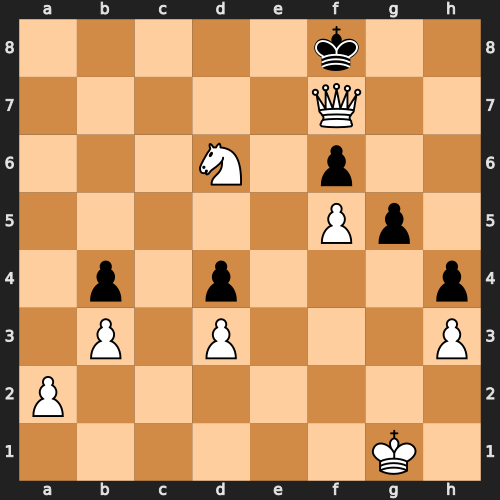

Game finished: white wins by checkmate


In [12]:
import chess
import chess.svg
import chess.engine
from IPython.display import display, clear_output

bot_black = True
model = load_model('chessbot_neural_network.h5')

board = chess.Board()
display(chess.svg.board(board=board, size=500))
while is_game_finished(board) == False:
    try:
        if bot_black:
            move = str(input("Enter your move: "))
            if move == "quit" or move == "exit" or move == "stop": break
            uci_move = check_move(board, move)
            board = show_board(board, uci_move)
        if is_game_finished(board): break

        board_onehot = one_hot_encode_board(board)
        value, policy = model.predict(np.expand_dims(board_onehot, axis=0))
        MoveMapper = ChessMoveMapper(board, policy)
        actions = MoveMapper.probabilities_to_actions()
        actions = sorted(actions, key=lambda x: x[1], reverse=True)
        best_move = actions[0][0]
        best_move = board.parse_uci(best_move)
        board = show_board(board, best_move)

        bot_black = True
    except ValueError as e:
        print(e)